<a href="https://colab.research.google.com/github/sakurararann/sakurararann.github.io/blob/main/KEGG_N_Glycan_%E8%A9%A6%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N-Glycan Biosynthesis Pathway - Homo Sapiens (Human)

# Ê∫ñÂÇô„Åô„Çã„Åπ„Åç„Éï„Ç°„Ç§„É´
- **hsa00510.xml** from KEGG(https://www.kegg.jp/pathway/hsa00510)
- **rna_tissue_consensus.tsv** from HPA(https://www.proteinatlas.org/humanproteome/tissue/data#consensus_tissues_rna)

##„Åì„ÅÆXML„Éá„Éº„Çø„ÅÆÊ¶ÇË¶Å
Á≥ñÈéñ‚ÜíÁ≥ñÈéñÔºà‰Ωø„Çè„Çå„Å¶„ÅÑ„ÇãÈÖµÁ¥†Ôºâ„ÅÆÊÉÖÂ†±„ÅåÂÖ•„Å£„Å¶„ÅÑ„ÇãÔºé

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

tree = ET.parse("hsa00510.xml")
root = tree.getroot()

entries = []
for entry in root.findall("./entry"):
    entries.append({
        "id": entry.get("id"),
        "type": entry.get("type"),
        "name": entry.get("name"),
        "graphics_name": entry.find("graphics").get("name") if entry.find("graphics") is not None else ""
    })

df = pd.DataFrame(entries)
print(df.head(5))

   id      type           name                           graphics_name
0  39      gene     hsa:199857             ALG14, CMS15, IDDEBF, MEPCA
1  40      gene      hsa:54344           DPM3, CDG1O, MDDGB15, MDDGC15
2  41      gene       hsa:8818                             DPM2, CDG1U
3  42       map  path:hsa00513  Various types of N-glycan biosynthesis
4  43  compound      gl:G10596                                  G10596


##ÂèØË¶ñÂåñ
Cytoscape„ÅßÂèØË¶ñÂåñ„Åß„Åç„Çã„Çà„ÅÜ„Å´„Éá„Éº„Çø„Çí‰øùÂ≠ò

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx

# === „Éï„Ç°„Ç§„É´Âêç„ÇíÊåáÂÆö ===
KGML_FILE = "hsa00510.xml"
OUTPUT_GRAPHML = "glycan_synthesis_only.graphml"

# === None „ÇíÈò≤„Åê‰æøÂà©Èñ¢Êï∞ ===
def safe(value):
    return value if value is not None else ""

# === XML„Çí„Éë„Éº„Çπ ===
tree = ET.parse(KGML_FILE)
root = tree.getroot()

# === EntryÔºàcompound„Å†„ÅëÔºâ ===
entries = []
for entry in root.findall("./entry"):
    if entry.get("type") == "compound":
        entries.append({
            "id": safe(entry.get("id")),
            "type": safe(entry.get("type")),
            "name": safe(entry.get("name")),
            "graphics_name": safe(
                entry.find("graphics").get("name") if entry.find("graphics") is not None else ""
            )
        })
df_entry = pd.DataFrame(entries)
print("=== Compound Entries ===")
print(df_entry.head())

# === ReactionÔºàÂü∫Ë≥™‚ÜíÁîüÊàêÁâ©Ôºâ ===
reactions = []
for reaction in root.findall("./reaction"):
    reaction_id = safe(reaction.get("id"))
    reaction_name = safe(reaction.get("name"))  # ECÁï™Âè∑„ÅåÂÖ•„Çã
    reaction_type = safe(reaction.get("type"))
    for substrate in reaction.findall("substrate"):
        for product in reaction.findall("product"):
            reactions.append({
                "reaction_id": reaction_id,
                "reaction_name": reaction_name,
                "reaction_type": reaction_type,
                "substrate": safe(substrate.get("name")),
                "product": safe(product.get("name"))
            })
df_reaction = pd.DataFrame(reactions)
print("\n=== Reactions ===")
print(df_reaction.head())

# === NetworkX DiGraph ===
G = nx.DiGraph()

# === „Éé„Éº„ÉâËøΩÂä†Ôºàcompound„ÅÆ„ÅøÔºâ ===
for _, row in df_entry.iterrows():
    G.add_node(
        row["id"],
        type=safe(row["type"]),
        name=safe(row["name"]),
        label=safe(row["graphics_name"])
    )

# === Reaction„Ç®„ÉÉ„Ç∏ÔºàÂü∫Ë≥™‚ÜíÁîüÊàêÁâ©„ÄÅÈÖµÁ¥†ÊÉÖÂ†±‰ªò„ÅçÔºâ ===
for _, row in df_reaction.iterrows():
    substrate_matches = df_entry[df_entry["name"] == row["substrate"]]
    product_matches = df_entry[df_entry["name"] == row["product"]]
    if not substrate_matches.empty and not product_matches.empty:
        substrate_id = substrate_matches["id"].values[0]
        product_id = product_matches["id"].values[0]

        # ECÁï™Âè∑„Çí enzyme Â±ûÊÄß„Å®„Åó„Å¶‰ªò‰∏é
        G.add_edge(
            substrate_id,
            product_id,
            edge_type="reaction",
            enzyme=row["reaction_name"],      # ECÁï™Âè∑ or KOÁï™Âè∑
            reaction_name=row["reaction_name"],  # ‚úÖ Â∑ÆÂàÜ„ÉÜ„Éº„Éñ„É´„Å®‰∏ÄËá¥„Åï„Åõ„Çã„Åü„ÇÅ„Å´ÂøÖÈ†à
            reaction_id=row["reaction_id"],      # ‚úÖ ÂøÖË¶Å„Å™„Çâ ID „ÇÇÊÆã„Åô
            reaction_type=row["reaction_type"]
        )
    else:
        print(f"Skipped: {row['substrate']} -> {row['product']}")

print(f"\n=== Graph Summary ===")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# === GraphML‰øùÂ≠ò ===
nx.write_graphml(G, OUTPUT_GRAPHML)
print(f"\n‚úÖ GraphML saved to: {OUTPUT_GRAPHML}")

=== Compound Entries ===
   id      type       name graphics_name
0  43  compound  gl:G10596        G10596
1  48  compound  gl:G00022        G00022
2  49  compound  gl:G00021        G00021
3  50  compound  gl:G00020        G00020
4  51  compound  gl:G00019        G00019

=== Reactions ===
  reaction_id reaction_name reaction_type   substrate     product
0          39     rn:R05970  irreversible   gl:G00001   gl:G00002
1          40     rn:R01009  irreversible  cpd:C00096  cpd:C03862
2          40     rn:R01009  irreversible  cpd:C00110  cpd:C03862
3          41     rn:R01009  irreversible  cpd:C00096  cpd:C03862
4          41     rn:R01009  irreversible  cpd:C00110  cpd:C03862
Skipped: gl:G10618 -> gl:G10598
Skipped: gl:G10617 -> gl:G10595
Skipped: gl:G10614 -> gl:G00003

=== Graph Summary ===
Nodes: 40
Edges: 41

‚úÖ GraphML saved to: glycan_synthesis_only.graphml


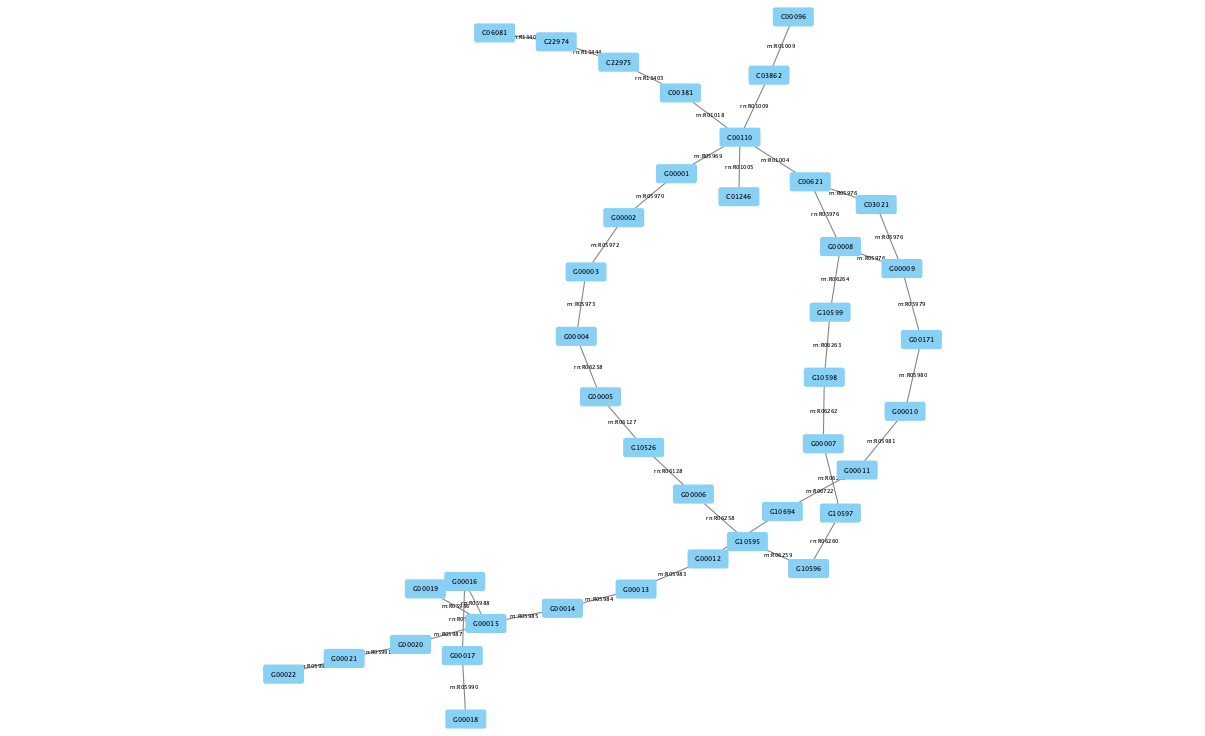

In [ ]:
# === ReactionÔºàÂü∫Ë≥™‚ÜíÁîüÊàêÁâ©Ôºâ === „ÅØ„Åô„Åß„Å´ÊäΩÂá∫Ê∏à„Åø„Å®„Åó„Å¶

# „Éë„Çπ„Ç¶„Çß„Ç§„ÅßÁôªÂ†¥„Åô„ÇãÈÖµÁ¥†ÔºàECÁï™Âè∑Ôºâ„ÅÆ„É¶„Éã„Éº„ÇØ‰∏ÄË¶ß
used_ec_numbers = df_reaction["reaction_name"].unique()

print("=== „Åì„ÅÆ„Éë„Çπ„Ç¶„Çß„Ç§„Åß‰Ωø„Çè„Çå„Å¶„ÅÑ„ÇãÈÖµÁ¥†ÔºàECÁï™Âè∑Ôºâ ===")
for ec in used_ec_numbers:
    print(ec)

=== „Åì„ÅÆ„Éë„Çπ„Ç¶„Çß„Ç§„Åß‰Ωø„Çè„Çå„Å¶„ÅÑ„ÇãÈÖµÁ¥†ÔºàECÁï™Âè∑Ôºâ ===
rn:R05970
rn:R01009
rn:R06264
rn:R06263
rn:R06262
rn:R06260
rn:R06259
rn:R06258
rn:R05991
rn:R01004
rn:R05988
rn:R05992
rn:R05989
rn:R05990
rn:R05986
rn:R05985
rn:R05984
rn:R05983
rn:R06722
rn:R05987
rn:R05980
rn:R05979
rn:R06128
rn:R05976
rn:R01005
rn:R06261
rn:R06127
rn:R06238
rn:R05973
rn:R05972
rn:R05969
rn:R01018
rn:R05981
rn:R13444
rn:R12479
rn:R13402
rn:R13403


## ÈÖµÁ¥†„ÅÆID„Åã„ÇâÂêçÂâç„Çí„Ç≤„ÉÉ„Éà

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import requests

# === „Éï„Ç°„Ç§„É´ÊåáÂÆö ===
KGML_FILE = "hsa00510.xml"

def safe(value):
    return value if value is not None else ""

# === XML„É≠„Éº„Éâ & reactionÊäΩÂá∫ ===
tree = ET.parse(KGML_FILE)
root = tree.getroot()

# === Reaction IDs „ÇíÊäΩÂá∫ ===
reactions = []
for reaction in root.findall("./reaction"):
    reaction_id = safe(reaction.get("id"))
    reaction_name = safe(reaction.get("name"))  # rn:XXXXX
    reaction_type = safe(reaction.get("type"))
    for substrate in reaction.findall("substrate"):
        for product in reaction.findall("product"):
            reactions.append({
                "reaction_id": reaction_id,
                "reaction_name": reaction_name,  # Reaction ID
                "reaction_type": reaction_type,
                "substrate": safe(substrate.get("name")),
                "product": safe(product.get("name"))
            })

df_reaction = pd.DataFrame(reactions)

# === ÁôªÂ†¥„Åô„Çã Reaction ID „Çí„É¶„Éã„Éº„ÇØ„Å´ÊäΩÂá∫ ===
reaction_ids = sorted(df_reaction["reaction_name"].unique())
print("=== ÁôªÂ†¥„Åô„Çã Reaction IDs ===")
for rn in reaction_ids:
    print(rn)

# === KEGG REST API Èñ¢Êï∞ ===

# Reaction ID ‚Üí ECÁï™Âè∑
def get_ec_numbers_from_reaction(rn_id):
    url = f"https://rest.kegg.jp/get/{rn_id}"
    response = requests.get(url)
    ec_numbers = []
    if response.ok:
        for line in response.text.split("\n"):
            if line.startswith("ENZYME"):
                parts = line.split()
                ec_numbers = parts[1:]  # ENZYME „ÅÆÂæå„Å´Ë§áÊï∞„ÅÆECÁï™Âè∑„Åå‰∏¶„Å∂Â†¥Âêà„ÅÇ„Çä
                break
    return ec_numbers

# ECÁï™Âè∑ ‚Üí KEGG Gene IDs
def get_gene_ids_from_ec(ec_number):
    url = f"https://rest.kegg.jp/link/hsa/enzyme:{ec_number}"
    response = requests.get(url)
    gene_ids = []
    if response.ok:
        lines = response.text.strip().split("\n")
        for line in lines:
            parts = line.split("\t")
            if len(parts) == 2:
                gene_ids.append(parts[1])
    return gene_ids

# KEGG Gene ID ‚Üí Gene SymbolÔºàSYMBOLË°åÂÑ™ÂÖà„ÄÅNAME fallbackÔºâ
def get_gene_symbol(gene_id):
    url = f"https://rest.kegg.jp/get/{gene_id}"
    response = requests.get(url)
    symbol = ""
    if response.ok:
        for line in response.text.split("\n"):
            if line.startswith("SYMBOL") and not symbol:
                parts = line.split()
                if len(parts) >= 2:
                    symbol = parts[1].replace(",", "")
            elif line.startswith("NAME") and not symbol:
                parts = line.split()
                if len(parts) >= 2:
                    symbol = parts[1].replace(",", "")
    return symbol

# === Reaction ID ‚Üí ECÁï™Âè∑ ‚Üí Gene Symbol „ÇíÂÖ®Â±ïÈñã ===

mapping_rows = []

for rn in reaction_ids:
    ec_numbers = get_ec_numbers_from_reaction(rn)
    if ec_numbers:
        for ec in ec_numbers:
            gene_ids = get_gene_ids_from_ec(ec)
            if gene_ids:
                for gid in gene_ids:
                    symbol = get_gene_symbol(gid)
                    mapping_rows.append({
                        "Reaction_ID": rn,
                        "EC": ec,
                        "Gene_Symbol": symbol
                    })
            else:
                mapping_rows.append({
                    "Reaction_ID": rn,
                    "EC": ec,
                    "Gene_Symbol": ""
                })
    else:
        mapping_rows.append({
            "Reaction_ID": rn,
            "EC": "",
            "Gene_Symbol": ""
        })

# === DataFrameÂåñ„Åó„Å¶ÂàóÈ†Ü„ÇíÂõ∫ÂÆö ===
df_map = pd.DataFrame(mapping_rows, columns=["Reaction_ID", "EC", "Gene_Symbol"])

print("\n=== Reaction ‚Üí EC ‚Üí Gene Symbol ===")
print(df_map.head(20))

# === CSV‰øùÂ≠òÔºàÂàóÈ†Ü„Çí‰øù„Å£„Åü„Åæ„ÅæÔºâ ===
df_map.to_csv("reaction_ec_gene_mapping_expanded.csv", index=False)
print("\n‚úÖ reaction_ec_gene_mapping_expanded.csv „Çí‰øùÂ≠ò„Åó„Åæ„Åó„ÅüÔºÅÔºàË§áÊï∞ÂØæÂøúÔºâ")

=== ÁôªÂ†¥„Åô„Çã Reaction IDs ===
rn:R01004
rn:R01005
rn:R01009
rn:R01018
rn:R05969
rn:R05970
rn:R05972
rn:R05973
rn:R05976
rn:R05979
rn:R05980
rn:R05981
rn:R05983
rn:R05984
rn:R05985
rn:R05986
rn:R05987
rn:R05988
rn:R05989
rn:R05990
rn:R05991
rn:R05992
rn:R06127
rn:R06128
rn:R06238
rn:R06258
rn:R06259
rn:R06260
rn:R06261
rn:R06262
rn:R06263
rn:R06264
rn:R06722
rn:R12479
rn:R13402
rn:R13403
rn:R13444

=== Reaction ‚Üí EC ‚Üí Gene Symbol ===
   Reaction_ID         EC Gene_Symbol
0    rn:R01004   3.6.1.43      DOLPP1
1    rn:R01005  2.4.1.117        ALG5
2    rn:R01009   2.4.1.83        DPM1
3    rn:R01018  2.7.1.108        DOLK
4    rn:R05969   2.7.8.15      DPAGT1
5    rn:R05970  2.4.1.141       ALG14
6    rn:R05970  2.4.1.141       ALG13
7    rn:R05972  2.4.1.142        ALG1
8    rn:R05973  2.4.1.132        ALG2
9    rn:R05976  2.4.99.18       STT3B
10   rn:R05976  2.4.99.18       STT3A
11   rn:R05979  3.2.1.106        MOGS
12   rn:R05980  3.2.1.207       GANAB
13   rn:R05981  3.2.1.2

## ÈÖµÁ¥†„Åã„ÇâTPM value„ÇíÂèñÂæó
https://www.proteinatlas.org/humanproteome/tissue/data#consensus_tissues_rna

In [ ]:
import pandas as pd

# Reaction-EC-Gene
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")

# HPA consensus
df_hpa = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")

# liver
df_liver = df_hpa[df_hpa["Tissue"] == "liver"]
df_liver_merged = df_map.merge(
    df_liver[["Gene name", "nTPM"]],
    left_on="Gene_Symbol",
    right_on="Gene name",
    how="left"
).drop(columns=["Gene name"])
df_liver_merged.to_csv("reaction_ec_gene_with_tpm_liver.csv", index=False)

# kidney
df_kidney = df_hpa[df_hpa["Tissue"] == "kidney"]
df_kidney_merged = df_map.merge(
    df_kidney[["Gene name", "nTPM"]],
    left_on="Gene_Symbol",
    right_on="Gene name",
    how="left"
).drop(columns=["Gene name"])
df_kidney_merged.to_csv("reaction_ec_gene_with_tpm_kidney.csv", index=False)

print("‚úÖ liver & kidney version created!")

‚úÖ liver & kidney version created!


ËáìÂô®„Åî„Å®„Å´„Éû„ÉÉ„Éî„É≥„Ç∞„Å®„Åó„Å¶‰øùÂ≠ò

In [ ]:
import pandas as pd

# Ë™≠„ÅøËæº„Åø
df_hpa = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")

# ÁµÑÁπîÊï∞„ÅÆÁ¢∫Ë™ç
tissues = df_hpa["Tissue"].unique()
print(f"ÂÖ®Tissue„ÅÆÊï∞: {len(tissues)}")
print("Tissue„ÅÆ‰∏ÄË¶ß:", tissues)
# Reaction-EC-Gene „Éû„ÉÉ„Éî„É≥„Ç∞„ÅÆË™≠„ÅøËæº„Åø
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")

# ÂêÑÁµÑÁπî„Å´„Å§„ÅÑ„Å¶„Éû„ÉÉ„Éî„É≥„Ç∞„Åó„Å¶‰øùÂ≠ò
for tissue in tissues:
    df_tissue = df_hpa[df_hpa["Tissue"] == tissue]
    df_merged = df_map.merge(
        df_tissue[["Gene name", "nTPM"]],
        left_on="Gene_Symbol",
        right_on="Gene name",
        how="left"
    ).drop(columns=["Gene name"])

    filename = f"reaction_ec_gene_with_tpm_{tissue.replace(' ', '_')}.csv"
    df_merged.to_csv(filename, index=False)
    print(f"‚úÖ {tissue} „Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü ‚Üí {filename}")


ÂÖ®Tissue„ÅÆÊï∞: 50
Tissue„ÅÆ‰∏ÄË¶ß: ['adipose tissue' 'adrenal gland' 'amygdala' 'appendix' 'basal ganglia'
 'bone marrow' 'breast' 'cerebellum' 'cerebral cortex' 'cervix'
 'choroid plexus' 'colon' 'duodenum' 'endometrium' 'epididymis'
 'esophagus' 'fallopian tube' 'gallbladder' 'heart muscle'
 'hippocampal formation' 'hypothalamus' 'kidney' 'liver' 'lung'
 'lymph node' 'midbrain' 'ovary' 'pancreas' 'parathyroid gland'
 'pituitary gland' 'placenta' 'prostate' 'rectum' 'retina'
 'salivary gland' 'seminal vesicle' 'skeletal muscle' 'skin'
 'small intestine' 'smooth muscle' 'spinal cord' 'spleen' 'stomach'
 'testis' 'thymus' 'thyroid gland' 'tongue' 'tonsil' 'urinary bladder'
 'vagina']
‚úÖ adipose tissue „Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü ‚Üí reaction_ec_gene_with_tpm_adipose_tissue.csv
‚úÖ adrenal gland „Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü ‚Üí reaction_ec_gene_with_tpm_adrenal_gland.csv
‚úÖ amygdala „Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü ‚Üí reaction_ec_gene_with_tpm_amygdala.csv
‚úÖ appendix „Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü ‚Üí reaction_ec

ËÇùËáì„Åß„ÄÅÊúâÂäπ„Å™Á≥ñÈéñÂêàÊàêÁµåË∑Ø„ÇíÈÄö„Åó„Å¶„ÄÅnTPM„Å´Âü∫„Å•„ÅÑ„Å¶ÊµÅ„Åõ„ÅüÊúÄÂ§ß„ÅÆÊµÅÈáè

In [ ]:
import networkx as nx
import pandas as pd

# 1. Á≥ñÈéñ„Éë„Çπ„Ç¶„Çß„Ç§ÊßãÈÄ†Ë™≠„ÅøËæº„Åø
G_base = nx.read_graphml("glycan_synthesis_only.graphml")
print(f"‚úÖ G_base: {len(G_base.nodes)} nodes, {len(G_base.edges)} edges")

# 2. ÈÅ∫‰ºùÂ≠êÁô∫ÁèæÔºà‰æãÔºöliverÔºâ
df_expr = pd.read_csv("reaction_ec_gene_with_tpm_liver.csv")
df_expr = df_expr[df_expr["nTPM"].notna() & (df_expr["nTPM"] > 1)]
valid_reactions = set(df_expr["Reaction_ID"].unique())
print(f"‚úÖ TPM > 1: {len(valid_reactions)} reactions")

# 3. capacity‰ªò„Åç„Ç∞„É©„Éï‰ΩúÊàêÔºàTPM„Çí‰Ωø„ÅÜÔºâ
cap_dict = df_expr.set_index("Reaction_ID")["nTPM"].to_dict()
G = nx.DiGraph()

for u, v, data in G_base.edges(data=True):
    rid = data.get("reaction_name", "").strip()  # ‚ÜêÁ©∫ÁôΩÂØæÁ≠ñ
    if rid in cap_dict:
        G.add_edge(u, v, capacity=cap_dict[rid])

# 4. „Çπ„Éº„Éë„Éº„ÇΩ„Éº„ÇπÔºè„Ç∑„É≥„ÇØ„ÅÆËøΩÂä†
source = "SuperSource"
sink = "SuperSink"
G.add_node(source)
G.add_node(sink)

# ÂßãÁÇπÂÄôË£úÔºöin_degree == 0ÔºàÂÖ•Âè£Ôºâ
for node in G.nodes:
    if node not in [source, sink] and G.in_degree(node) == 0 and G.out_degree(node) > 0:
        G.add_edge(source, node, capacity=float("inf"))

# ÁµÇÁÇπÂÄôË£úÔºöout_degree == 0ÔºàÂá∫Âè£Ôºâ
for node in G.nodes:
    if node not in [source, sink] and G.out_degree(node) == 0 and G.in_degree(node) > 0:
        G.add_edge(node, sink, capacity=float("inf"))

print(f"‚úÖ G_weighted: {len(G.nodes)} nodes, {len(G.edges)} edges (with source/sink)")

# 5. ÊúÄÂ§ß„Éï„É≠„ÉºË®àÁÆó
try:
    flow_val, flow_dict = nx.maximum_flow(G, source, sink, capacity="capacity")
    print(f"‚úÖ ÊúÄÂ§ß„Éï„É≠„ÉºÂÄ§: {flow_val}")
except Exception as e:
    print(f"‚ùå ÊúÄÂ§ß„Éï„É≠„ÉºË®àÁÆóÂ§±Êïó: {e}")


‚úÖ G_base: 40 nodes, 41 edges
‚úÖ TPM > 1: 35 reactions
‚úÖ G_weighted: 40 nodes, 46 edges (with source/sink)
‚úÖ ÊúÄÂ§ß„Éï„É≠„ÉºÂÄ§: 98.39999999999999


‚úÖ G_base loaded: 40 nodes, 41 edges
‚úÖ adipose_tissue: MaxFlow = 63.800000000000004
‚úÖ adrenal_gland: MaxFlow = 84.19999999999999
‚úÖ amygdala: MaxFlow = 37.3
‚úÖ appendix: MaxFlow = 48.9
‚úÖ basal_ganglia: MaxFlow = 39.7
‚úÖ bone_marrow: MaxFlow = 64.2
‚úÖ breast: MaxFlow = 58.0
‚úÖ cerebellum: MaxFlow = 41.9
‚úÖ cerebral_cortex: MaxFlow = 48.5
‚úÖ cervix: MaxFlow = 57.2
‚úÖ choroid_plexus: MaxFlow = 43.4
‚úÖ colon: MaxFlow = 67.9
‚úÖ duodenum: MaxFlow = 67.60000000000001
‚úÖ endometrium: MaxFlow = 58.6
‚úÖ epididymis: MaxFlow = 56.800000000000004
‚úÖ esophagus: MaxFlow = 74.0
‚úÖ fallopian_tube: MaxFlow = 49.699999999999996
‚úÖ gallbladder: MaxFlow = 60.30000000000001
‚úÖ heart_muscle: MaxFlow = 74.5
‚úÖ hippocampal_formation: MaxFlow = 40.199999999999996
‚úÖ hypothalamus: MaxFlow = 39.4
‚úÖ kidney: MaxFlow = 72.9
‚úÖ liver: MaxFlow = 98.39999999999999
‚úÖ lung: MaxFlow = 50.5
‚úÖ lymph_node: MaxFlow = 69.8
‚úÖ midbrain: MaxFlow = 40.0
‚úÖ ovary: MaxFlow = 54.2
‚úÖ pancreas: MaxF

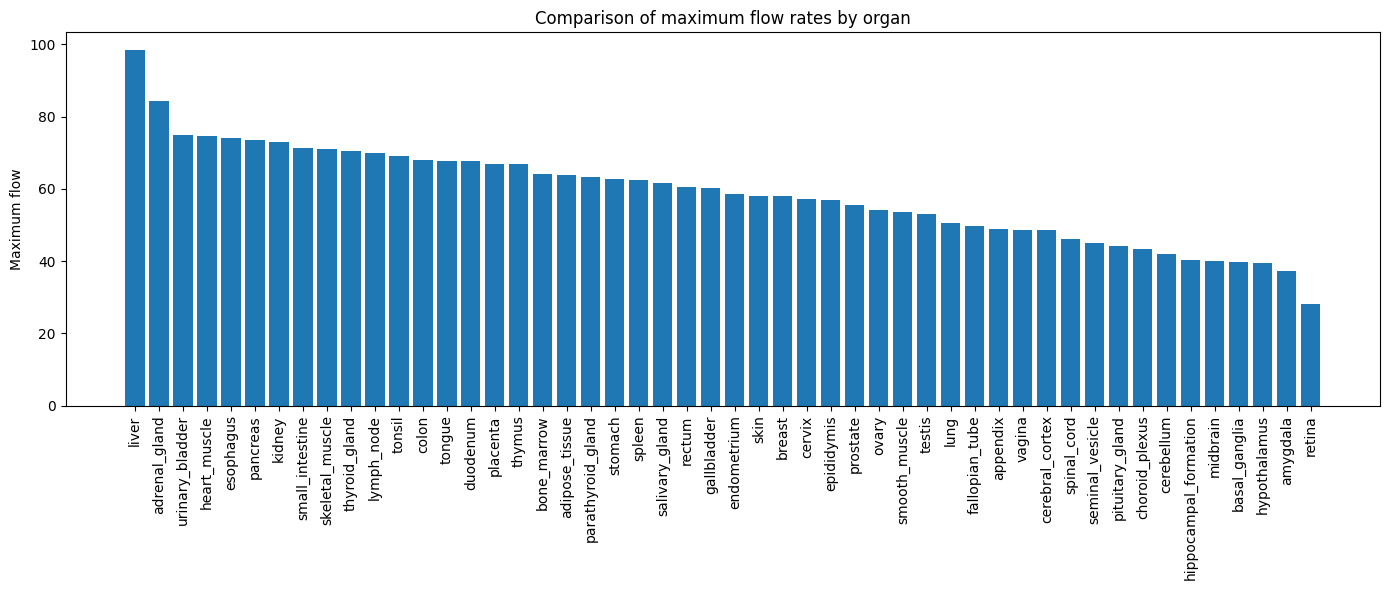

In [ ]:
import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt

# Á≥ñÈéñ„Éë„Çπ„Ç¶„Çß„Ç§ÊßãÈÄ†Ë™≠„ÅøËæº„ÅøÔºàÂÖ±ÈÄöÔºâ
G_base = nx.read_graphml("glycan_synthesis_only.graphml")
print(f"‚úÖ G_base loaded: {len(G_base.nodes)} nodes, {len(G_base.edges)} edges")

# ÂêÑËáìÂô®„ÅÆCSV„Éï„Ç°„Ç§„É´„ÇíÊé¢„ÅôÔºà‰∫ãÂâç„Å´‰Ωú„Å£„Åü„ÇÑ„Å§Ôºâ
files = [f for f in os.listdir() if f.startswith("reaction_ec_gene_with_tpm_") and f.endswith(".csv")]

results = []

# ÂêÑËáìÂô®„Åî„Å®„Å´ÊúÄÂ§ß„Éï„É≠„Éº„ÇíË®àÁÆó
for file in sorted(files):
    tissue = file.replace("reaction_ec_gene_with_tpm_", "").replace(".csv", "")
    df_expr = pd.read_csv(file)
    df_expr = df_expr[df_expr["nTPM"].notna() & (df_expr["nTPM"] > 1)]
    valid_reactions = set(df_expr["Reaction_ID"].unique())
    cap_dict = df_expr.set_index("Reaction_ID")["nTPM"].to_dict()

    # capacity‰ªò„Åç„Ç∞„É©„ÉïÊßãÁØâ
    G = nx.DiGraph()
    for u, v, data in G_base.edges(data=True):
        rid = data.get("reaction_name", "").strip()
        if rid in cap_dict:
            G.add_edge(u, v, capacity=cap_dict[rid])

    # „Çπ„Éº„Éë„Éº„ÇΩ„Éº„ÇπÔºè„Ç∑„É≥„ÇØ
    source = "SuperSource"
    sink = "SuperSink"
    G.add_node(source)
    G.add_node(sink)

    for node in G.nodes:
        if node not in [source, sink] and G.in_degree(node) == 0 and G.out_degree(node) > 0:
            G.add_edge(source, node, capacity=float("inf"))
        if node not in [source, sink] and G.out_degree(node) == 0 and G.in_degree(node) > 0:
            G.add_edge(node, sink, capacity=float("inf"))

    # ÊúÄÂ§ß„Éï„É≠„ÉºË®àÁÆó
    try:
        flow_val, _ = nx.maximum_flow(G, source, sink, capacity="capacity")
        print(f"‚úÖ {tissue}: MaxFlow = {flow_val}")
    except Exception as e:
        flow_val = 0
        print(f"‚ùå {tissue}: „Ç®„É©„Éº ‚Üí {e}")

    results.append({"Tissue": tissue, "MaxFlow": flow_val})

# ÁµêÊûú„Çí‰øùÂ≠ò
df_result = pd.DataFrame(results).sort_values("MaxFlow", ascending=False)
df_result.to_csv("tissue_maxflow_capacityTPM_result.csv", index=False)
print("üì¶ ÁµêÊûú„Çí tissue_maxflow_capacityTPM_result.csv „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü")

# ÂèØË¶ñÂåñ
plt.figure(figsize=(14, 6))
plt.bar(df_result["Tissue"], df_result["MaxFlow"])
plt.xticks(rotation=90)
plt.ylabel("Maximum flow")
plt.title("Comparison of maximum flow rates by organ")
plt.tight_layout()
plt.savefig("maxflow_comparison_by_tissue.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd

# ÊúÄÂ§ß„Éï„É≠„ÉºÁµêÊûúË™≠„ÅøËæº„Åø
df_flow = pd.read_csv("tissue_maxflow_capacityTPM_result.csv")

# „Éà„ÉÉ„Éó3 & „Éú„Éà„É†3 ËáìÂô®
top3 = df_flow.sort_values("MaxFlow", ascending=False).head(3)
bottom3 = df_flow.sort_values("MaxFlow", ascending=True).head(3)

print("üî∫ Top 3 tissues:")
print(top3)
print("\nüîª Bottom 3 tissues:")
print(bottom3)


üî∫ Top 3 tissues:
            Tissue  MaxFlow
0            liver     98.4
1    adrenal_gland     84.2
2  urinary_bladder     74.8

üîª Bottom 3 tissues:
          Tissue  MaxFlow
49        retina     28.0
48      amygdala     37.3
47  hypothalamus     39.4


In [ ]:
import pandas as pd

# ÊúÄÂ§ß„Éï„É≠„ÉºÁµêÊûúË™≠„ÅøËæº„Åø
df_flow = pd.read_csv("tissue_maxflow_capacityTPM_result.csv")

# EC‰ªò„Åç„ÅÆ„Éû„ÉÉ„Éó„Éá„Éº„Çø
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")
df_map_ec = df_map[["Reaction_ID", "Gene_Symbol", "EC"]].dropna(subset=["EC"])

# === TopËáìÂô®Âá¶ÁêÜ ===
top_tissue = df_flow.sort_values("MaxFlow", ascending=False)["Tissue"].iloc[0]
print(f"üß† ÊúÄÂ§ß„Éï„É≠„Éº1‰Ωç„ÅÆËáìÂô®Ôºö{top_tissue}")

file_top = f"reaction_ec_gene_with_tpm_{top_tissue}.csv"
df_top = pd.read_csv(file_top)
df_top = df_top[df_top["nTPM"].notna() & (df_top["nTPM"] > 1)]
df_top = df_top.merge(df_map_ec, on=["Reaction_ID", "Gene_Symbol"], how="left")

top_genes = df_top.sort_values("nTPM", ascending=False).drop_duplicates("Gene_Symbol").head(10)
print("üîù È´òTPMÈÖµÁ¥†ÔºàTopËáìÂô®Ôºâ:")
print(top_genes[["Reaction_ID", "Gene_Symbol", "nTPM", "EC_y"]].rename(columns={"EC_y": "EC"}))

# === BottomËáìÂô®Âá¶ÁêÜ ===
bottom_tissue = df_flow.sort_values("MaxFlow", ascending=True)["Tissue"].iloc[0]
print(f"üí§ ÊúÄÂ∞è„Éï„É≠„Éº„ÅÆËáìÂô®Ôºö{bottom_tissue}")

file_bot = f"reaction_ec_gene_with_tpm_{bottom_tissue}.csv"
df_bot = pd.read_csv(file_bot)
df_bot = df_bot[df_bot["nTPM"].notna() & (df_bot["nTPM"] > 1)]
df_bot = df_bot.merge(df_map_ec, on=["Reaction_ID", "Gene_Symbol"], how="left")

bottom_genes = df_bot.sort_values("nTPM", ascending=False).drop_duplicates("Gene_Symbol").head(10)
print("üîª È´òTPMÈÖµÁ¥†ÔºàBottomËáìÂô®Ôºâ:")
print(bottom_genes[["Reaction_ID", "Gene_Symbol", "nTPM", "EC_y"]].rename(columns={"EC_y": "EC"}))


üß† ÊúÄÂ§ß„Éï„É≠„Éº1‰Ωç„ÅÆËáìÂô®Ôºöliver
üîù È´òTPMÈÖµÁ¥†ÔºàTopËáìÂô®Ôºâ:
   Reaction_ID Gene_Symbol   nTPM         EC
24   rn:R05990     ST6GAL1  480.8    2.4.3.1
18   rn:R05987      MGAT4B  270.4  2.4.1.145
13   rn:R05981       GANAB  166.5  3.2.1.207
40   rn:R12479      MAN1A1  150.0  3.2.1.113
14   rn:R05983       MGAT1  143.3  2.4.1.101
21   rn:R05989     B4GALT1   87.2   2.4.1.38
9    rn:R05976       STT3B   72.6  2.4.99.18
10   rn:R05976       STT3A   66.9  2.4.99.18
2    rn:R01009        DPM1   60.3   2.4.1.83
1    rn:R01005        ALG5   60.0  2.4.1.117
üí§ ÊúÄÂ∞è„Éï„É≠„Éº„ÅÆËáìÂô®Ôºöretina
üîª È´òTPMÈÖµÁ¥†ÔºàBottomËáìÂô®Ôºâ:
   Reaction_ID Gene_Symbol  nTPM         EC
13   rn:R05981       GANAB  77.0  3.2.1.207
15   rn:R05984      MAN2A2  72.6  3.2.1.114
10   rn:R05976       STT3A  38.8  2.4.99.18
9    rn:R05976       STT3B  37.4  2.4.99.18
14   rn:R05983       MGAT1  28.3  2.4.1.101
22   rn:R05989     B4GALT1  25.4   2.4.1.38
2    rn:R01009        DPM1  21.1   2.4.1.83
4

Áõ¥Âàó„É¢„Éá„É´
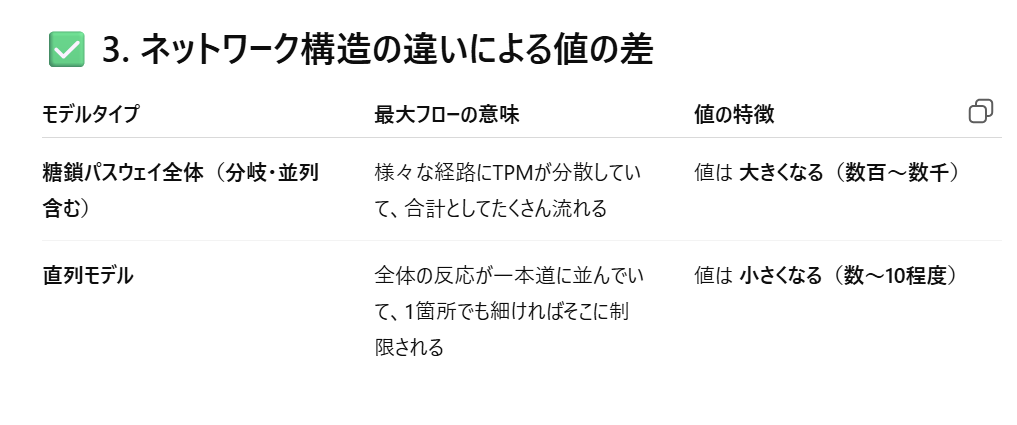

‚úÖ adipose tissue  MaxFlow = 0.30
‚úÖ adrenal gland   MaxFlow = 1.00
‚úÖ amygdala        MaxFlow = 0.90
‚úÖ appendix        MaxFlow = 0.00
‚úÖ basal ganglia   MaxFlow = 1.00
‚úÖ bone marrow     MaxFlow = 0.00
‚úÖ breast          MaxFlow = 0.00
‚úÖ cerebellum      MaxFlow = 0.70
‚úÖ cerebral cortex MaxFlow = 1.90
‚úÖ cervix          MaxFlow = 0.20
‚úÖ choroid plexus  MaxFlow = 0.00
‚úÖ colon           MaxFlow = 0.40
‚úÖ duodenum        MaxFlow = 0.00
‚úÖ endometrium     MaxFlow = 0.00
‚úÖ epididymis      MaxFlow = 0.80
‚úÖ esophagus       MaxFlow = 0.00
‚úÖ fallopian tube  MaxFlow = 0.10
‚úÖ gallbladder     MaxFlow = 0.10
‚úÖ heart muscle    MaxFlow = 1.60
‚úÖ hippocampal formation MaxFlow = 0.80
‚úÖ hypothalamus    MaxFlow = 0.70
‚úÖ kidney          MaxFlow = 0.10
‚úÖ liver           MaxFlow = 0.10
‚úÖ lung            MaxFlow = 0.10
‚úÖ lymph node      MaxFlow = 0.00
‚úÖ midbrain        MaxFlow = 0.80
‚úÖ ovary           MaxFlow = 0.00
‚úÖ pancreas        MaxFlow = 0.10
‚úÖ parathyroi

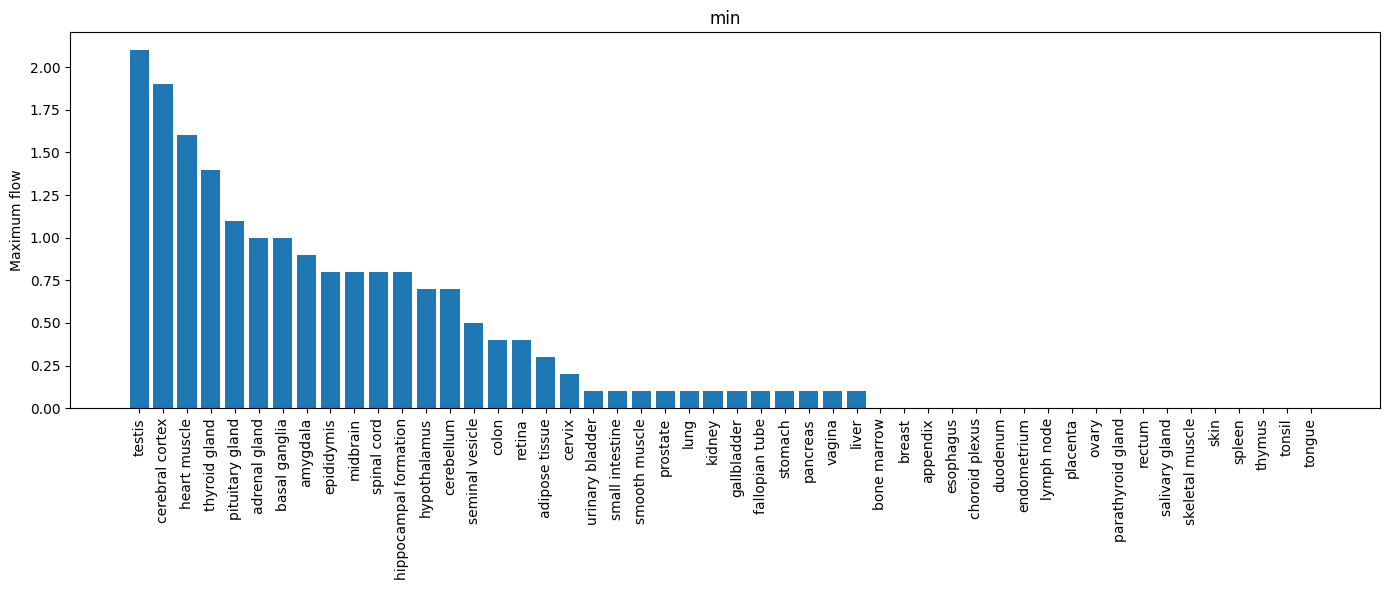

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# === „Éá„Éº„ÇøË™≠„ÅøËæº„Åø ===
df_map  = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")   # Reaction ‚Üî EC ‚Üî Gene
df_expr = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")  # ÂêÑÁµÑÁπî„ÅÆ nTPM

# === ÂèçÂøú„É™„Çπ„Éà„ÇíÂèñÂæó„Åó„Å¶Áõ¥Âàó„É¢„Éá„É´„ÅÆ„Éô„Éº„Çπ„Çí‰ΩúÊàê ===
reactions = df_map["Reaction_ID"].unique().tolist()
G_base = nx.DiGraph()
for i in range(len(reactions) - 1):
    u, v = reactions[i], reactions[i+1]
    G_base.add_edge(u, v)  # ÂÆπÈáè„ÅØÂæå„ÅßË®≠ÂÆö

# === ÁµêÊûúÊ†ºÁ¥çÁî® ===
results = []

# === ÂêÑÁµÑÁπî„Åî„Å®„Å´ÊúÄÂ§ß„Éï„É≠„Éº„ÇíË®àÁÆó ===
for tissue in sorted(df_expr["Tissue"].unique()):
    # Ôºà1ÔºâÂΩìË©≤ÁµÑÁπî„ÅÆÁô∫ÁèæÈáè„Å†„ÅëÊäΩÂá∫„Åó„ÄÅËæûÊõ∏„Å´„Åô„Çã
    df_t = df_expr[df_expr["Tissue"] == tissue][["Gene name", "nTPM"]]
    expr_dict = df_t.set_index("Gene name")["nTPM"].to_dict()

    # Ôºà2Ôºâ„Éô„Éº„Çπ„Ç∞„É©„Éï„Çí„Ç≥„Éî„Éº„Åó„ÄÅÂêÑ„Ç®„ÉÉ„Ç∏„Å´ capacity „ÇíË®≠ÂÆö
    G = G_base.copy()
    for u, v in G.edges():
        # uÔºàReaction_IDÔºâ„Å´Á¥ê„Å•„ÅèÈÅ∫‰ºùÂ≠ê„ÇíÊäΩÂá∫
        genes = df_map[df_map["Reaction_ID"] == u]["Gene_Symbol"].dropna().unique()
        # „Åù„ÅÆ‰∏≠„ÅÆÁô∫ÁèæÈáè„É™„Çπ„Éà
        caps = [ expr_dict.get(g, 0.0) for g in genes ]
        # „ÄåÊúÄÂ§ßÁô∫ÁèæÈáè„Äç„Çí capacity „Å´Ôºà„ÅäÂ•Ω„Åø„Åß sum()/mean() „Å´Â§âÊõ¥ÂèØÔºâ
        G[u][v]["capacity"] = max(caps) if caps else 0.0

    # Ôºà3Ôºâ„Çπ„Éº„Éë„Éº„ÇΩ„Éº„ÇπÔºè„Ç∑„É≥„ÇØ„ÇíËøΩÂä†
    source, sink = "SuperSource", "SuperSink"
    G.add_node(source); G.add_node(sink)
    # ÂßãÁÇπÔºàin_degree==0Ôºâ‚Üí source, ÁµÇÁÇπÔºàout_degree==0Ôºâ‚Üí sink
    for n in reactions:
        if G.in_degree(n) == 0:
            G.add_edge(source, n, capacity=float("inf"))
        if G.out_degree(n) == 0:
            G.add_edge(n, sink, capacity=float("inf"))

    # Ôºà4ÔºâÊúÄÂ§ß„Éï„É≠„ÉºË®àÁÆó
    flow_value, _ = nx.maximum_flow(G, source, sink, capacity="capacity")
    results.append((tissue, flow_value))
    print(f"‚úÖ {tissue:<15} MaxFlow = {flow_value:.2f}")

# === DataFrameÂåñ„Åó„Å¶„ÇΩ„Éº„Éà ===
df_res = pd.DataFrame(results, columns=["Tissue","MaxFlow"])
df_res = df_res.sort_values("MaxFlow", ascending=False)

# === ÁµêÊûú„Çí‰øùÂ≠ò ===
df_res.to_csv("tissue_maxflow_result.csv", index=False)
print("‚Üí tissue_maxflow_result.csv „Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü")

# === Ê£í„Ç∞„É©„Éï„ÅßÂèØË¶ñÂåñ ===
plt.figure(figsize=(14,6))
plt.bar(df_res["Tissue"], df_res["MaxFlow"])
plt.xticks(rotation=90)
plt.ylabel("Maximum flow")
plt.title("min")
plt.tight_layout()
plt.show()


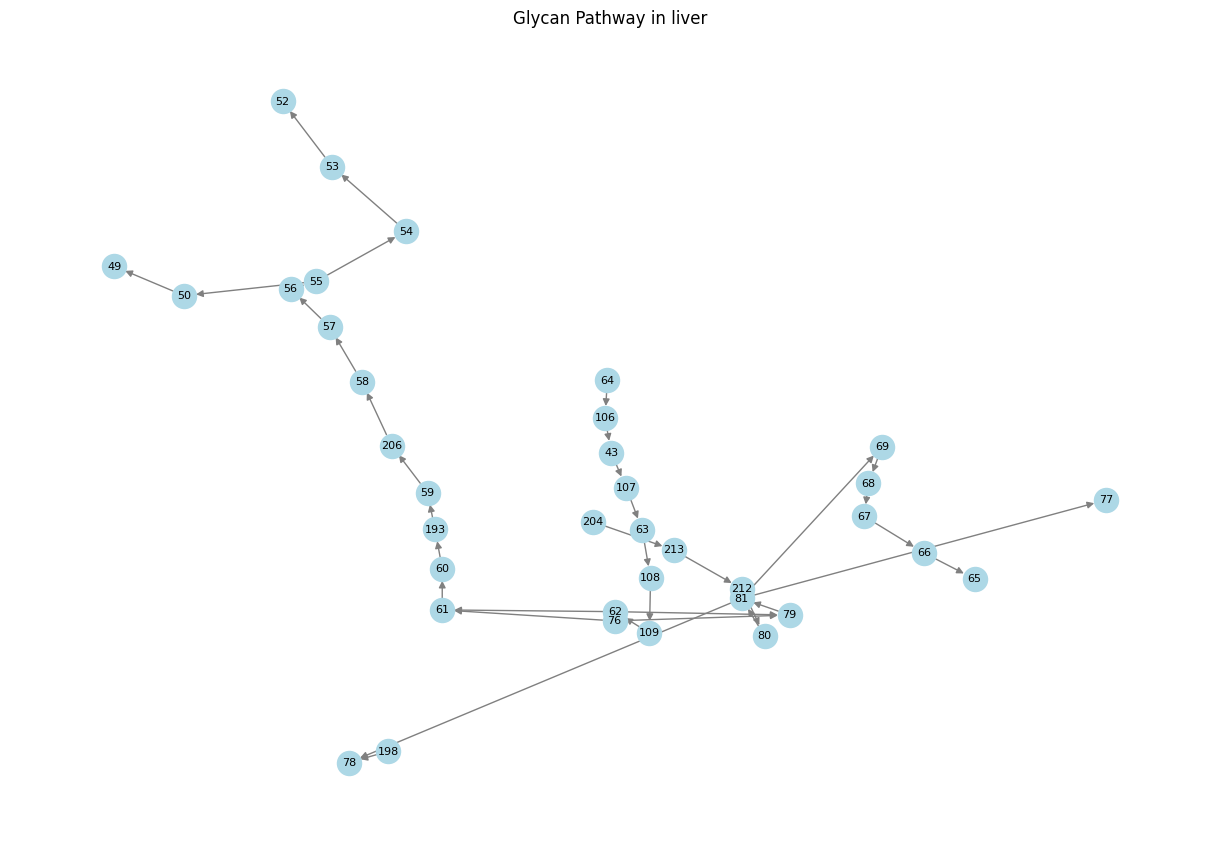

In [ ]:
import pandas as pd

df_rna = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")

# Tissue„Åî„Å®„Å´Áô∫Áèæ„Åó„Å¶„ÅÑ„ÇãÈÅ∫‰ºùÂ≠ê„ÅÆ‰∏ÄË¶ß„ÇíÂèñÂæóÔºà‰æã: nTPM > 1„Åß„Éï„Ç£„É´„ÇøÔºâ
tissue_gene_dict = {
    tissue: group[group["nTPM"] > 1]["Gene name"].unique().tolist()
    for tissue, group in df_rna.groupby("Tissue")
}
import networkx as nx

# Reaction-EC-GeneÊÉÖÂ†±Ôºà„Éû„ÉÉ„Éî„É≥„Ç∞„Éï„Ç°„Ç§„É´Ôºâ
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")

# Á≥ñÈéñ„Éë„Çπ„Ç¶„Çß„Ç§„ÅÆÂèçÂøú„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØÔºà‰æãÔºöGraphML„Åß‰Ωú„Å£„Åü„ÇÑ„Å§Ôºâ
G_reaction = nx.read_graphml("glycan_synthesis_only.graphml")

tissue_networks = {}

for tissue, genes in tissue_gene_dict.items():
    G_tissue = nx.DiGraph()

    # ÈÅ∫‰ºùÂ≠ê„ÅåÈñ¢‰∏é„Åó„Å¶„ÅÑ„ÇãÂèçÂøú„Å†„Åë„ÇíÊäΩÂá∫
    reactions = df_map[df_map["Gene_Symbol"].isin(genes)]["Reaction_ID"].unique()

    for u, v, data in G_reaction.edges(data=True):
        if data.get("reaction_name") in reactions:
            G_tissue.add_edge(u, v, **data)

    tissue_networks[tissue] = G_tissue

import matplotlib.pyplot as plt

tissue = "liver"  # ÂèØË¶ñÂåñ„Åó„Åü„ÅÑÈÉ®‰ΩçÂêç
G = tissue_networks[tissue]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300, font_size=8)
plt.title(f"Glycan Pathway in {tissue}")
plt.show()


##ËáìÂô®„ÅÆÂ∑Æ„Çí„Å®„Å£„Å¶„Åø„Çã

In [ ]:
import pandas as pd

# ÂêÑÁµÑÁπî„Éï„Ç°„Ç§„É´Ë™≠„ÅøËæº„Åø
df_liver = pd.read_csv("reaction_ec_gene_with_tpm_liver.csv")
df_kidney = pd.read_csv("reaction_ec_gene_with_tpm_kidney.csv")

# Reaction_ID „Åî„Å®„Å´ nTPM „ÇíÂπ≥Âùá„ÉªÂêàË®à„Åô„Çã
df_liver_grp = df_liver.groupby("Reaction_ID").agg({"nTPM": ["mean", "sum"]}).reset_index()
df_liver_grp.columns = ["Reaction_ID", "TPM_liver_mean", "TPM_liver_sum"]

df_kidney_grp = df_kidney.groupby("Reaction_ID").agg({"nTPM": ["mean", "sum"]}).reset_index()
df_kidney_grp.columns = ["Reaction_ID", "TPM_kidney_mean", "TPM_kidney_sum"]

df_diff = df_liver_grp.merge(
    df_kidney_grp,
    on="Reaction_ID",
    how="outer"
).fillna(0)  # „Å©„Å°„Çâ„Åã„Å´„Å™„ÅÑÂ†¥Âêà„ÅØ0„ÅßÂüã„ÇÅ„Çã

df_diff["TPM_diff_mean"] = df_diff["TPM_liver_mean"] - df_diff["TPM_kidney_mean"]
df_diff["TPM_diff_sum"] = df_diff["TPM_liver_sum"] - df_diff["TPM_kidney_sum"]

print(df_diff.head())

df_diff.to_csv("reaction_tpm_diff_liver_vs_kidney.csv", index=False)
print("‚úÖ Â∑ÆÂàÜ„ÉÜ„Éº„Éñ„É´ saved: reaction_tpm_diff_liver_vs_kidney.csv")

  Reaction_ID  TPM_liver_mean  TPM_liver_sum  TPM_kidney_mean  TPM_kidney_sum  \
0   rn:R01004            21.8           21.8              5.8             5.8   
1   rn:R01005            60.0           60.0             39.7            39.7   
2   rn:R01009            60.3           60.3             44.6            44.6   
3   rn:R01018            10.2           10.2              8.8             8.8   
4   rn:R05969            20.1           20.1             12.1            12.1   

   TPM_diff_mean  TPM_diff_sum  
0           16.0          16.0  
1           20.3          20.3  
2           15.7          15.7  
3            1.4           1.4  
4            8.0           8.0  
‚úÖ Â∑ÆÂàÜ„ÉÜ„Éº„Éñ„É´ saved: reaction_tpm_diff_liver_vs_kidney.csv


In [ ]:
import networkx as nx
import pandas as pd

# GraphML Ë™≠„ÅøËæº„Åø
G = nx.read_graphml("glycan_synthesis_only.graphml")

# Â∑ÆÂàÜ„ÉÜ„Éº„Éñ„É´
df_diff = pd.read_csv("reaction_tpm_diff_liver_vs_kidney.csv")

# Edge„ÅÆ reaction_name „Å´ÂØæÂøú„Åó„Å¶Â∑ÆÂàÜ„ÇíÁ™ÅÂêà
for u, v, data in G.edges(data=True):
    if data.get("edge_type") == "reaction":
        reaction_id = data.get("reaction_name")  # ‰æã: rn:R05983
        row = df_diff[df_diff["Reaction_ID"] == reaction_id]
        if not row.empty:
            data["TPM_liver_mean"] = row["TPM_liver_mean"].values[0]
            data["TPM_kidney_mean"] = row["TPM_kidney_mean"].values[0]
            data["TPM_diff_mean"] = row["TPM_diff_mean"].values[0]

# Â∑ÆÂàÜ„ÇíËºâ„Åõ„ÅüÊñ∞„Åó„ÅÑ GraphML ‰øùÂ≠ò
nx.write_graphml(G, "glycan_pathway_with_tpm_diff.graphml")
print("‚úÖ Â∑ÆÂàÜ„ÇíËºâ„Åõ„Åü GraphML ‰øùÂ≠òÂÆå‰∫ÜÔºÅ")

‚úÖ Â∑ÆÂàÜ„ÇíËºâ„Åõ„Åü GraphML ‰øùÂ≠òÂÆå‰∫ÜÔºÅ


## TPM value„ÇíÈáç„Åø„Å´„Åó„Åü„Ç∞„É©„Éï„Çí‰ΩúÊàê
ËáìÂô®„Å´„Çà„Å£„Å¶ÂÄ§„ÅåÁï∞„Å™„ÇãÔºù„Ç≠„É£„Éë„Ç∑„ÉÜ„Ç£„ÅåÁï∞„Å™„Çã

In [ ]:
import networkx as nx
import pandas as pd

# ÂÖÉ„ÅÆ KEGG „Ç∞„É©„Éï
G = nx.read_graphml("glycan_synthesis_only.graphml")

# Â∑ÆÂàÜ„ÉÜ„Éº„Éñ„É´ÔºàReaction Âçò‰ΩçÔºâ
df_diff = pd.read_csv("reaction_tpm_diff_liver_vs_kidney.csv")

missing = []

# „Ç®„ÉÉ„Ç∏Â±ûÊÄß„Çí Reaction „Å´„Å†„Åë‰ªò‰∏é
for u, v, data in G.edges(data=True):
    if data.get("edge_type") == "reaction":
        # „Åæ„Åö reaction_name „ÇíË©¶„Åô
        reaction_id = data.get("reaction_name")

        # reaction_name „Åå„Å™„ÅÑÂ†¥Âêà„ÅØ reaction_id „Çí fallback „Å´„Åô„Çã
        if reaction_id is None or reaction_id == "":
            reaction_id = data.get("reaction_id")

        if reaction_id is None or reaction_id == "":
            missing.append(f"{u}->{v} Reaction edge „Å´ ID „Åå„Å™„ÅÑ")
            continue

        row = df_diff[df_diff["Reaction_ID"] == reaction_id]

        if not row.empty:
            data["TPM_liver_mean"] = float(row["TPM_liver_mean"].values[0])
            data["TPM_liver_sum"]  = float(row["TPM_liver_sum"].values[0])
            data["TPM_kidney_mean"] = float(row["TPM_kidney_mean"].values[0])
            data["TPM_kidney_sum"]  = float(row["TPM_kidney_sum"].values[0])
            data["TPM_diff_mean"]  = float(row["TPM_diff_mean"].values[0])
            data["TPM_diff_sum"]   = float(row["TPM_diff_sum"].values[0])
            data["weight_liver"]   = float(row["TPM_liver_mean"].values[0])
            data["weight_kidney"]  = float(row["TPM_kidney_mean"].values[0])
        else:
            missing.append(f"{u}->{v} Reaction_ID not matched: {reaction_id}")

print("‚úÖ Reaction edge „Å´ TPM_mean, TPM_sum „Çí‰∏°ÊñπËøΩÂä†„Åó„Åæ„Åó„Åü")

if missing:
    print("\n=== ‚ùå ‰∏ç‰∏ÄËá¥„ÉªIDÁÑ°„Åó ===")
    for m in missing:
        print(m)
else:
    print("\n‚úÖ ÂÖ®ÈÉ®‰∏ÄËá¥„Åó„Åæ„Åó„Åü")

# ‰øùÂ≠ò
nx.write_graphml(G, "glycan_pathway_with_tpm_mean_sum.graphml")
print("‚úÖ GraphML ‰øùÂ≠ò: glycan_pathway_with_tpm_mean_sum.graphml")

FileNotFoundError: [Errno 2] No such file or directory: 'reaction_tpm_diff_liver_vs_kidney.csv'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Ë™≠„ÅøËæº„Åø
G = nx.read_graphml("glycan_pathway_with_tpm_mean_sum.graphml")

# 2. ÂèØË¶ñÂåñÂØæË±°Ôºàreaction„Ç®„ÉÉ„Ç∏„ÅÆ„ÅøÔºâ
edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("edge_type") == "reaction"]

# 3. Â∑ÆÂàÜÔºàliver vs kidneyÔºâ„ÅÆÂèñ„ÇäÂá∫„Åó
colors = []
for u, v in edges:
    diff = G[u][v].get("TPM_diff_mean", 0)
    colors.append(diff)

# 4. „É¨„Ç§„Ç¢„Ç¶„ÉàÔºà„É©„É≥„ÉÄ„É† or springÔºâ
pos = nx.spring_layout(G, seed=42)

# 5. ÊèèÁîª
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightgray')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, edge_cmap=plt.cm.seismic, width=2)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), label="TPM_diff_mean (liver - kidney)")
plt.title("Glycan Pathway Reaction TPM Difference: Liver vs Kidney")
plt.axis("off")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'glycan_pathway_with_tpm_mean_sum.graphml'

##„ÅäË©¶„Åó„ÅßÊúÄÂ§ß„Éï„É≠„ÉºÂïèÈ°å„ÇíËß£„Åè
Âøµ„ÅÆÁÇ∫„ÅÆÂãï‰ΩúÁ¢∫Ë™ç„Åß„ÅôÔºéÂÖ®ÁÑ∂Ê≠£Á¢∫„Åò„ÇÉ„Å™„ÅÑ„ÅÆ„Åß„ÅîÊ≥®ÊÑè„ÇíÔºé

In [ ]:
import networkx as nx
import pandas as pd
from networkx.algorithms.flow import maximum_flow

# === GraphML Ë™≠„ÅøËæº„Åø ===
G = nx.read_graphml("glycan_pathway_with_tpm_mean_sum.graphml")

# === Reaction edge „Å´ capacity „Çí liver Áâà„ÅßË®≠ÂÆö ===
for u, v, data in G.edges(data=True):
    if data.get("edge_type") == "reaction":
        data["capacity"] = float(data.get("TPM_liver_sum", 0))

print("‚úÖ Reaction edge „Å´ capacity Ë®≠ÂÆöÂÆå‰∫Ü")

# === Source / Sink „ÇíÊäΩÂá∫ ===
sources = [n for n in G.nodes() if G.in_degree(n) == 0]
sinks   = [n for n in G.nodes() if G.out_degree(n) == 0]

print("Sources:", sources)
print("Sinks:", sinks)

# === flow_dict „Åã„ÇâÈ†ÜÂ∫è„Å§„Åç„Éë„Çπ„ÇíÂæ©ÂÖÉ„Åô„ÇãÈñ¢Êï∞Ôºàvisited„Å§„ÅçÔºâ ===
def get_flow_paths(flow_dict, source, sink):
    H = nx.DiGraph()
    for u, v_dict in flow_dict.items():
        for v, flow in v_dict.items():
            if flow > 0:
                H.add_edge(u, v, flow=flow)

    all_paths = []

    def dfs(u, path, bottleneck, visited):
        if u == sink:
            all_paths.append( (path[:], bottleneck) )
            return
        for v in H.successors(u):
            if v not in visited:
                edge_flow = H[u][v]['flow']
                if edge_flow > 0:
                    new_bottleneck = min(bottleneck, edge_flow)
                    visited.add(v)
                    dfs(v, path + [v], new_bottleneck, visited)
                    visited.remove(v)

    visited = set([source])
    dfs(source, [source], float('inf'), visited)

    return all_paths

# === ÂÖ®„Éö„Ç¢„ÅßÊúÄÂ§ß„Éï„É≠„Éº„ÇíË®àÁÆó & „Éë„ÇπÂàóÊåô ===
results = []

for s in sources:
    for t in sinks:
        if nx.has_path(G, s, t):
            flow_value, flow_dict = maximum_flow(G, s, t, capacity='capacity')
            paths = get_flow_paths(flow_dict, s, t)
            for path, path_flow in paths:
                results.append({
                    "source": s,
                    "sink": t,
                    "path": " ‚Üí ".join(path),
                    "path_flow": path_flow
                })
            print(f"‚úÖ {s} ‚Üí {t} | Total flow: {flow_value:.2f} | Paths found: {len(paths)}")
        else:
            print(f"‚ùå {s} ‚Üí {t} : No path")

# === DataFrame Âåñ ===
df_paths = pd.DataFrame(results).sort_values(by="path_flow", ascending=False)
print("\n=== All Flow Paths ===")
print(df_paths.head())

# === Sink Á≥ñÈéñ„Åî„Å®„ÅÆÊúÄÁµÇÁîüÊàêÈáè„ÇíÈõÜË®à ===
df_sink_sum = (
    df_paths.groupby("sink")["path_flow"]
    .sum()
    .reset_index()
    .sort_values(by="path_flow", ascending=False)
)

# sink „ÅÆÁ≥ñÈéñÂêç„ÇÇ‰ªò„Åë„Çã
sink_labels = []
for sink_id in df_sink_sum["sink"]:
    node_data = G.nodes[sink_id]
    label = node_data.get("label", sink_id)
    sink_labels.append(label)

df_sink_sum["sink_label"] = sink_labels

print("\n=== Sink-wise Total Generated Amounts ===")
print(df_sink_sum)

# === ‰øùÂ≠ò ===
df_paths.to_csv("glycan_pathway_flow_paths.csv", index=False)
df_sink_sum.to_csv("glycan_pathway_sink_totals.csv", index=False)
print("\n‚úÖ Flow paths saved: glycan_pathway_flow_paths.csv")
print("‚úÖ Sink total amounts saved: glycan_pathway_sink_totals.csv")

‚úÖ Reaction edge „Å´ capacity Ë®≠ÂÆöÂÆå‰∫Ü
Sources: ['76', '204', '198']
Sinks: ['48', '51', '52', '77', '78']
‚úÖ 76 ‚Üí 48 | Total flow: 0.10 | Paths found: 1
‚úÖ 76 ‚Üí 51 | Total flow: 0.20 | Paths found: 1
‚úÖ 76 ‚Üí 52 | Total flow: 3.30 | Paths found: 1
‚úÖ 76 ‚Üí 77 | Total flow: 21.80 | Paths found: 1
‚úÖ 76 ‚Üí 78 | Total flow: 21.80 | Paths found: 1


NetworkXError: The node 204 is not in the digraph.